# **Regression Analysis for Predicting Success on College Exams**

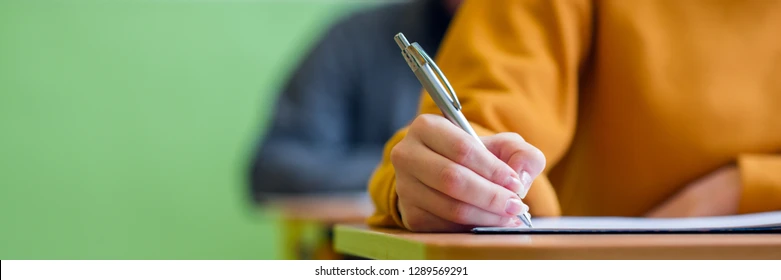

## **Business Understanding**


## **Data Understanding**




### **Collect Initial Data**

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


%matplotlib inline

In [5]:
#Collect inititial data - Load data into analysis tool
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')

### **Describe Data**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [7]:
data.isna().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [8]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [9]:
for col in numericals:
    print(data[col].describe())
    print()

count    6607.000000
mean       19.975329
std         5.990594
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        44.000000
Name: Hours_Studied, dtype: float64

count    6607.000000
mean       79.977448
std        11.547475
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: Attendance, dtype: float64

count    6607.00000
mean        7.02906
std         1.46812
min         4.00000
25%         6.00000
50%         7.00000
75%         8.00000
max        10.00000
Name: Sleep_Hours, dtype: float64

count    6607.000000
mean       75.070531
std        14.399784
min        50.000000
25%        63.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Previous_Scores, dtype: float64

count    6607.000000
mean        1.493719
std         1.230570
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Tutoring_Sessions

In [10]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3362
High      1908
Low       1337
Name: count, dtype: int64

Access_to_Resources
Medium    3319
High      1975
Low       1313
Name: count, dtype: int64

Extracurricular_Activities
Yes    3938
No     2669
Name: count, dtype: int64

Motivation_Level
Medium    3351
Low       1937
High      1319
Name: count, dtype: int64

Internet_Access
Yes    6108
No      499
Name: count, dtype: int64

Family_Income
Low       2672
Medium    2666
High      1269
Name: count, dtype: int64

Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64

School_Type
Public     4598
Private    2009
Name: count, dtype: int64

Peer_Influence
Positive    2638
Neutral     2592
Negative    1377
Name: count, dtype: int64

Learning_Disabilities
No     5912
Yes     695
Name: count, dtype: int64

Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64

Distance_from_Home
Near        3884
Moderate    1998
Fa

### **Explore Data**

In [11]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"].sort_values(ascending=False)

,Exam_Score
Exam_Score,1.000000
Attendance,0.581072
Hours_Studied,0.445455
Previous_Scores,0.175079
Tutoring_Sessions,0.156525
Physical_Activity,0.027824
Sleep_Hours,-0.017022


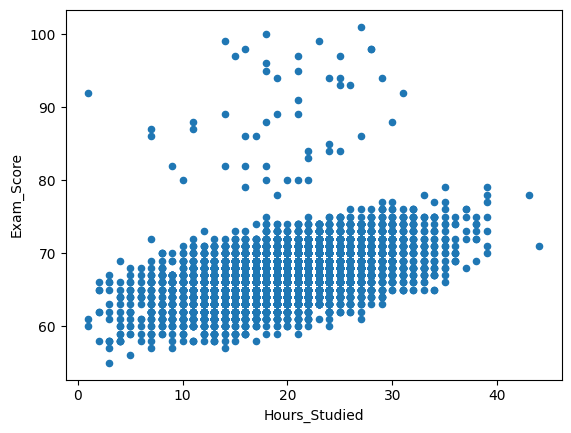

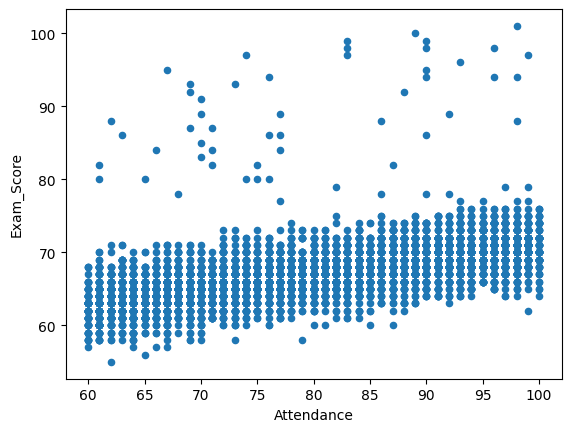

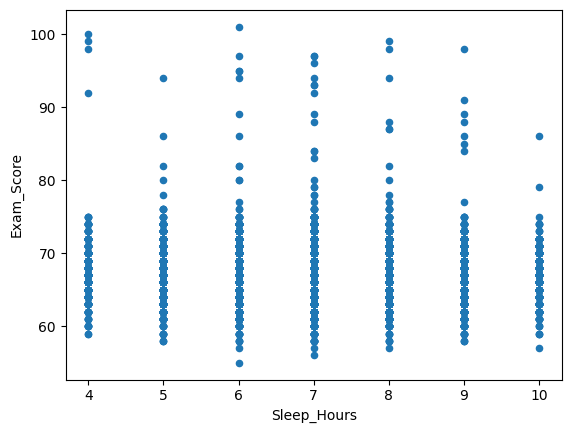

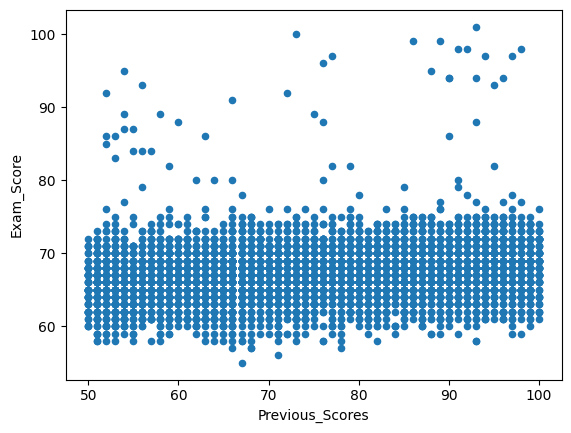

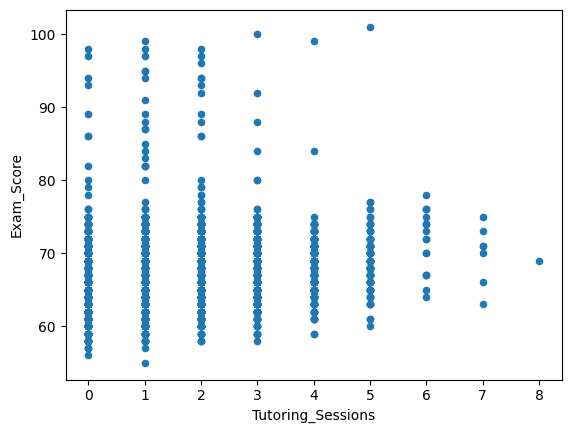

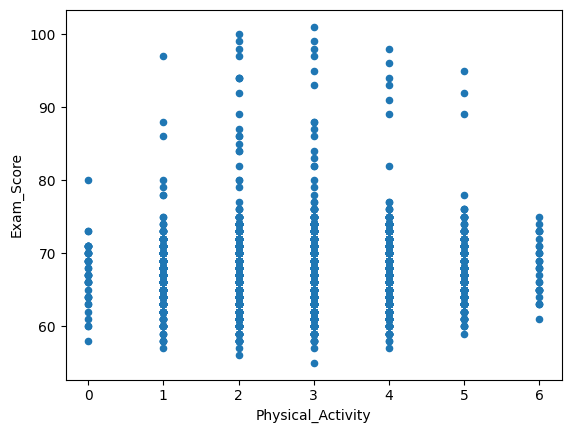

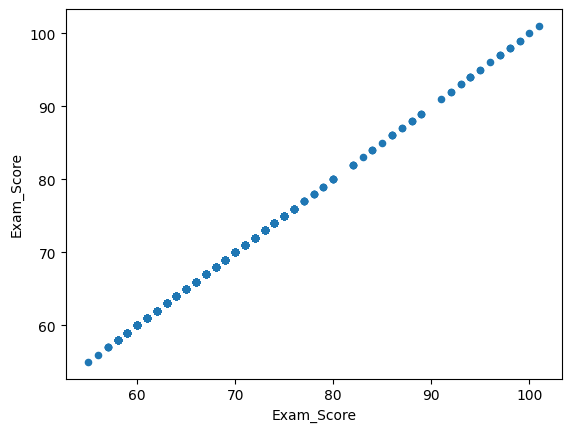

In [12]:
for col in data.corr(numeric_only=True).columns:
    data.plot.scatter(x=col, y='Exam_Score')

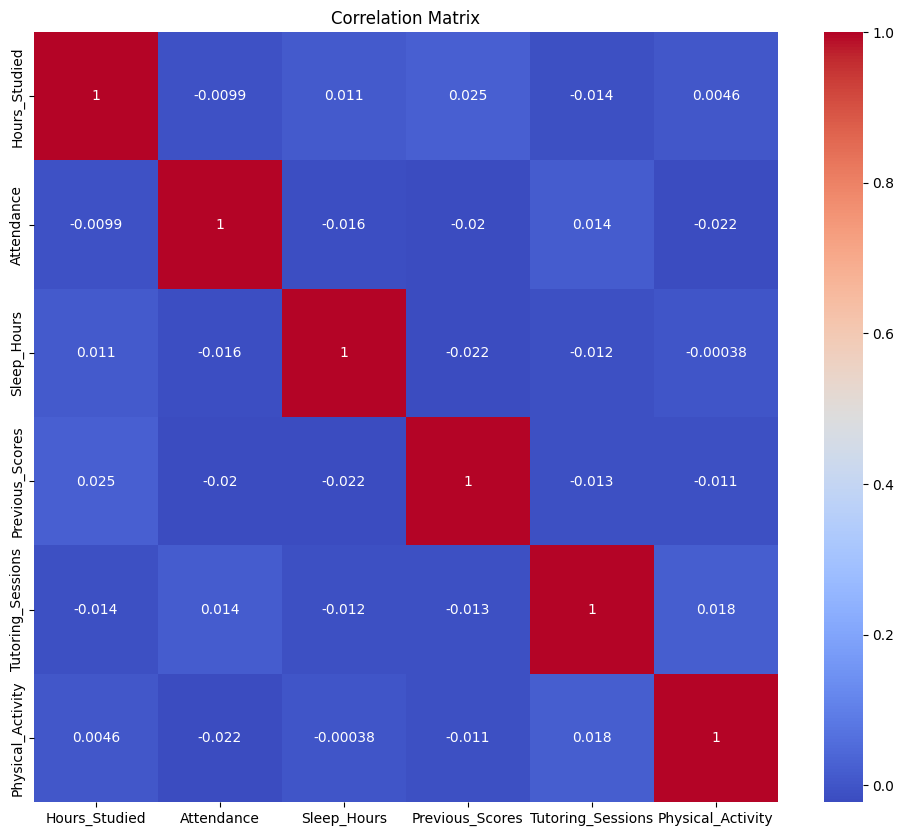

In [13]:
correlation_matrix = numericals.drop(columns='Exam_Score').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Source: [Stack Overflow](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792)

In [15]:
# Iterate over each categorical column and calculate Cramér's V with 'Exam_Score'
cramers_v_scores = {}
for col in categoricals.columns:
    cramers_v_scores[col] = cramers_v(categoricals[col], data['Exam_Score'])

    # Sort the Cramér's V scores in descending order
sorted_cramers_v = dict(sorted(cramers_v_scores.items(), key=lambda x: x[1], reverse=True))

# Print the sorted Cramér's V scores
for col, score in sorted_cramers_v.items():
    print(f"{col}: {score}")

Access_to_Resources: 0.14290480082319892
Parental_Involvement: 0.12724648209908054
Learning_Disabilities: 0.1214015524523443
Parental_Education_Level: 0.08261450208483652
Distance_from_Home: 0.0794498676350251
Peer_Influence: 0.0784667869738358
Extracurricular_Activities: 0.06843536624317961
Internet_Access: 0.06618045778186897
Motivation_Level: 0.06385428822724329
Family_Income: 0.06384672720556844
Teacher_Quality: 0.05279910484081827
Gender: 0.040667254636876295
School_Type: 0.0


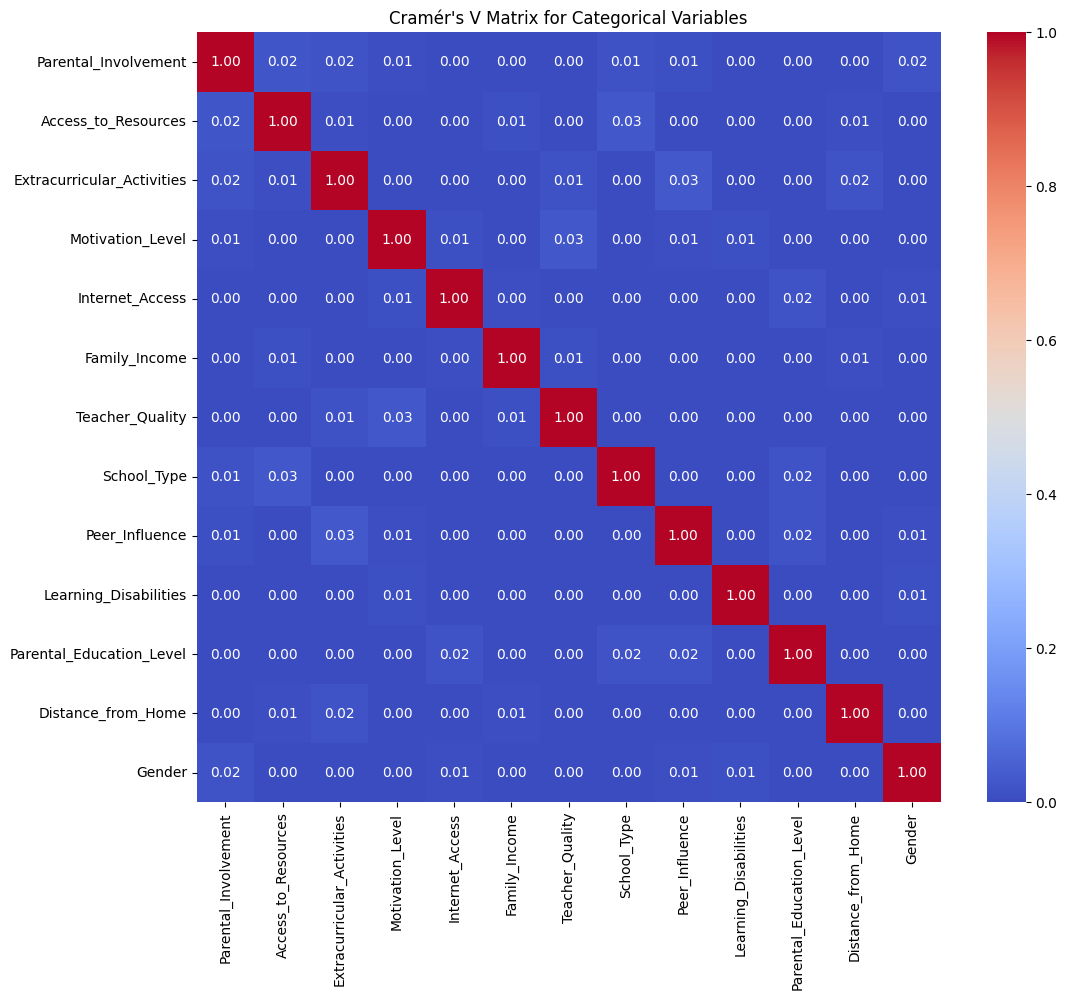

In [16]:
# Create an empty matrix to store Cramer's V values
cramers_v_matrix = pd.DataFrame(index=categoricals.columns, columns=categoricals.columns)

# Iterate through all pairs of categorical columns
for col1 in categoricals.columns:
    for col2 in categoricals.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(categoricals[col1], categoricals[col2])

# Convert the Cramér's V matrix to numeric type
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cramér\'s V Matrix for Categorical Variables')
plt.show()

### **Data Preparation**

In [17]:
#Drop Missing Values
data = data.dropna()

In [18]:
#fit a one hot encoder to the categorical
ohe = OneHotEncoder(drop='first')
categoricals_trans = ohe.fit_transform(categoricals)

In [19]:
#create a matrix from the transformed categorical data
categoricals_trans.todense()

matrix([[1., 0., 0., ..., 1., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 1.],
        ...,
        [0., 1., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 1., 0., 1.]])

In [20]:
#turn the matrix into a dataframe
categoricals_ohe = pd.DataFrame(categoricals_trans.todense(), columns=ohe.get_feature_names_out())

In [21]:
#combine the reformated categorical columns with the numerical columns
data = pd.concat([numericals, categoricals_ohe], axis=1)

In [22]:
data = data.dropna()

In [23]:
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Modeling**

In [25]:
#Prints Results of Regression Metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Function Source: [Stack Overflow](https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does)

In [26]:
#Create a single linear regression model using only the most correlated variable as a baseline
single_linear_regression = sm.OLS(endog=y_train, exog=sm.add_constant(X_train[['Attendance']]))
single_linear_regression_results = single_linear_regression.fit()
print(single_linear_regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     2664.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:24:13   Log-Likelihood:                -13642.
No. Observations:                5285   AIC:                         2.729e+04
Df Residuals:                    5283   BIC:                         2.730e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.4683      0.308    166.980      0.0

In [27]:
slr = LinearRegression()
slr.fit(X_train[['Attendance']], y_train)
y_pred = slr.predict(X_test[['Attendance']])
regression_results(y_test, y_pred)

explained_variance:  0.3476
mean_squared_log_error:  0.0018
r2:  0.3476
MAE:  2.1079
MSE:  9.2215
RMSE:  3.0367


In [28]:
multiple_lin_reg = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))
multiple_lin_reg_results = multiple_lin_reg.fit()
multiple_lin_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     444.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:24:13   Log-Likelihood:                -11382.
No. Observations:                5285   AIC:                         2.283e+04
Df Residuals:                    5254   BIC:                         2.303e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    41.9405      0.375    111.934      0.000      41.206      42.675
Hours_Studied                             0.2930      0.005     60.926      0.000       0.284       0.302
Attendance                                0.1988      0.003     79.343      0.000       0.194       0.204
Sleep_Hours                              -0.0127      0.020     -0.642      0.521      -0.051       0.026
Previous_Scores                           0.0490      0.002     24.433      0.000       0.045       0.053
Tutoring_Sessions                         0.5081      0.023     21.765      0.000       0.462       0.554
Physical_Activity                         0.1915      0.028      6.848      0.000       0.137       0.246
Parental_Involvement_Low                 -2.0029      0.084    -23.957      0.000      -2.167      -1.839
Parental_Involvement_Medium              -1.0713      0.067    -15.951      0.000      -1.203      -0.940
Access_to_Resources_Low                  -2.1002      0.084    -25.133      0.000      -2.264      -1.936
Access_to_Resources_Medium               -1.0329      0.067    -15.486      0.000      -1.164      -0.902
Extracurricular_Activities_Yes            0.5837      0.059      9.930      0.000       0.468       0.699
Motivation_Level_Low                     -1.0430      0.084    -12.423      0.000      -1.208      -0.878
Motivation_Level_Medium                  -0.5510      0.077     -7.190      0.000      -0.701      -0.401
Internet_Access_Yes                       0.9573      0.108      8.903      0.000       0.747       1.168
Family_Income_Low                        -1.1080      0.080    -13.860      0.000      -1.265      -0.951
Family_Income_Medium                     -0.6384      0.080     -7.966      0.000      -0.796      -0.481
Teacher_Quality_Low                      -1.0168      0.106     -9.564      0.000      -1.225      -0.808
Teacher_Quality_Medium                   -0.5533      0.065     -8.540      0.000      -0.680      -0.426
Teacher_Quality_nan                      -0.6126      0.276     -2.220      0.026      -1.154      -0.072
School_Type_Public                        0.0145      0.063      0.231      0.817      -0.108       0.138
Peer_Influence_Neutral                    0.5644      0.078      7.199      0.000       0.411       0.718
Peer_Influence_Positive                   1.0495      0.078     13.537      0.000       0.898       1.202
Learning_Disabilities_Yes                -0.8591      0.092     -9.319      0.000      -1.040      -0.678
Parental_Education_Level_High School     -0.4646      0.067     -6.937      0.000      -0.596      -0.333
Parental_Education_Level_Postgraduate     0.5105      0.084      6.098      0.000       0.346       0.675
Parental_

In [29]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.7701
mean_squared_log_error:  0.0005
r2:  0.7699
MAE:  0.4499
MSE:  3.2521
RMSE:  1.8034


In [30]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.6488
mean_squared_log_error:  0.0009
r2:  0.6469
MAE:  1.1896
MSE:  4.9909
RMSE:  2.234


In [32]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.5802
mean_squared_log_error:  0.0011
r2:  0.5802
MAE:  1.4413
MSE:  5.9333
RMSE:  2.4358


In [37]:
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)
y_pred = ransac.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.7718
mean_squared_log_error:  0.0005
r2:  0.7706
MAE:  0.4027
MSE:  3.2433
RMSE:  1.8009


In [48]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.6529
mean_squared_log_error:  0.0009
r2:  0.6506
MAE:  1.2363
MSE:  4.9391
RMSE:  2.2224
